# Predicting Insurance Costs
We'll be looking at the Medical Cost Data Set from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

For our regression problem, we're interested in how these different characteristics relate to the total medical cost. It's a continuous, positive number, which makes it a good candidate for a linear regression. We want to construct the best possible predictive model for the cost, given some information about the patient. Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
insurance = pd.read_csv('insurance.csv')
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


array([[<AxesSubplot:title={'center':'charges'}>]], dtype=object)

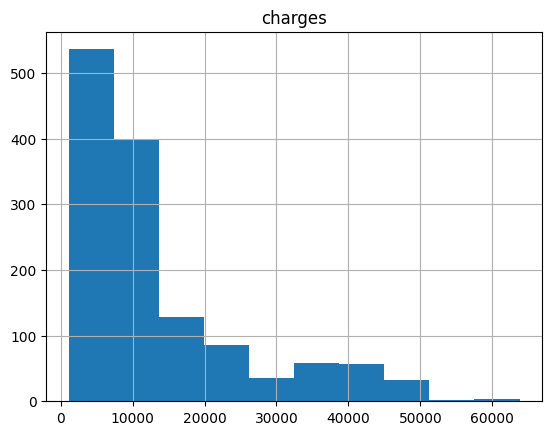

In [4]:
insurance.hist('charges')

The `charges` column is highly skewed to the right. Extremely costly insurance charges are more common than extremely small ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be worth it to log-transform the outcome.

array([[<AxesSubplot:title={'center':'log_charges'}>]], dtype=object)

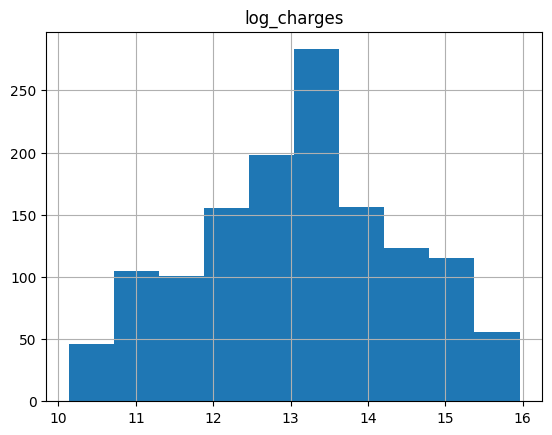

In [7]:
insurance['log_charges'] = np.log2(insurance['charges'])
insurance.hist('log_charges')

In [9]:
insurance.corr()

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


## Correlations
It looks like `age` plays the biggest factor in `charges` at 30% correlation, `bmi` comes in second with over 19%, and `children` in third with about 6%. 

<AxesSubplot:title={'center':'log_charges'}, xlabel='sex'>

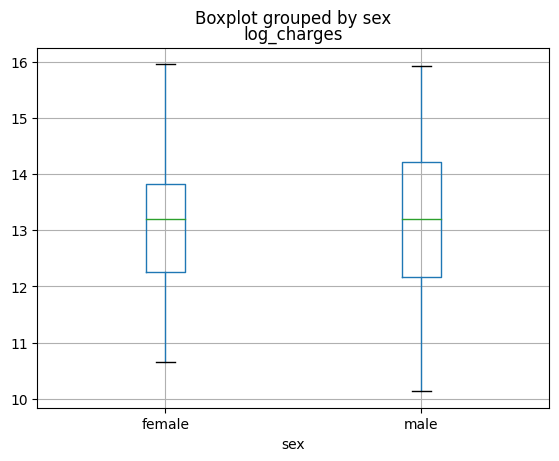

In [12]:
insurance.boxplot(column=['log_charges'], by='sex')

<AxesSubplot:title={'center':'log_charges'}, xlabel='smoker'>

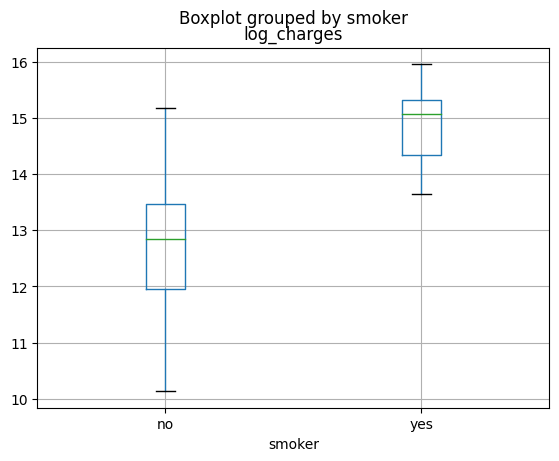

In [13]:
insurance.boxplot(column=['log_charges'], by='smoker')

<AxesSubplot:title={'center':'log_charges'}, xlabel='region'>

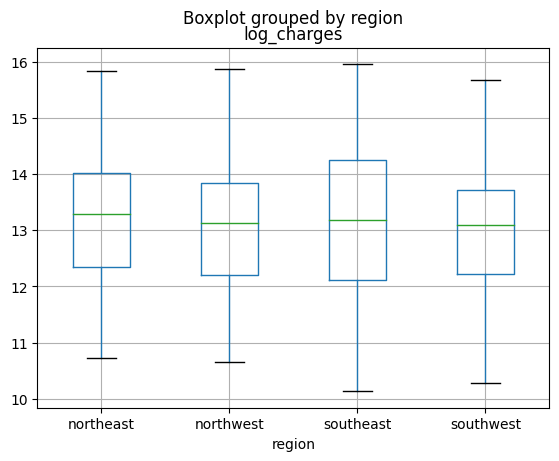

In [14]:
insurance.boxplot(column=['log_charges'], by='region')

<AxesSubplot:title={'center':'log_charges'}, xlabel='children'>

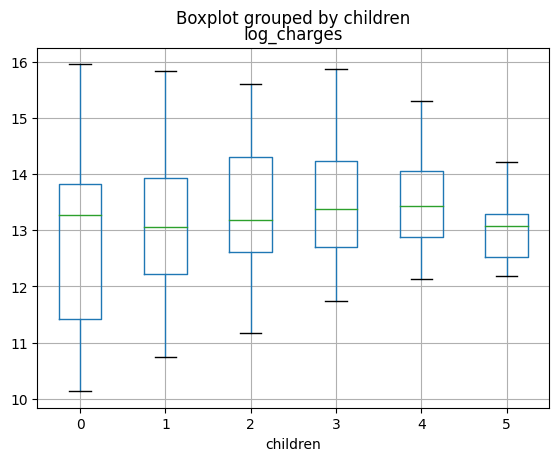

In [15]:
insurance.boxplot(column=['log_charges'], by='children')

Males seem to have a wider distribution of charges compared to women. Smokers have much higher costs than non-smokers. There doesn't seem tobe many appreciable differences between regions.

## Dividing the Data

Seeing that `age`, `smoker`, and `bmi` correlate the most with the outcome `charges`, we'll move forward with these features as our predictors in the model.

Let's divide the dataset into training and testing datasets.

In [16]:
insurance['is_smoker'] = (insurance['smoker'] == 'yes')
X = insurance[['age', 'bmi', 'is_smoker']]
y = insurance['log_charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Building the Model
Now that we've divided up the data into both a training and test set, we're ready to build our predictive linear model. 

In [17]:
# Training and checking model performance on training set
#building the model
model = LinearRegression()

# Get predicted values by model
#fitting the model
model.fit(X_train, y_train)

#getting the models predicted coefficients
y_prediction = model.predict(X_train)

# MSE on the log scale for the insurance charges
#getting the mean squared error of model
mean_squared_error(y_train, y_prediction)

0.45188410556701514

In [19]:
# MSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_train, y_prediction))

1.5712698365981919

In [21]:
# Coefficient of determination
r2_score(y_train, y_prediction)

0.7401147505859649

### Comments
The training MSE for the model is 0.454 and is 1.57 on the original scale. The 
$R^2$ indicates that the model can explain 74% of the variation in the log-insurance charges. Though optimistic, these preliminary results are promising.

## Residual Diagnostics
We have a working predictive model for medical costs. Before examining it more closely, we'll check how well the assumption of lenear regression are met.

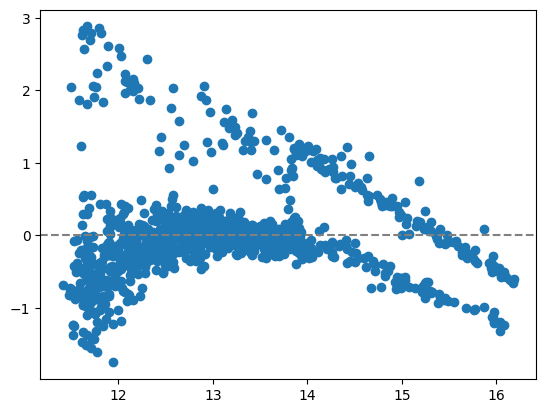

In [27]:
#checking the residuals
check = pd.DataFrame()
check['residuals'] = y_train - y_prediction
check['fitted'] = y_prediction

plt.scatter(x='fitted', y='residuals', data=check)
plt.axhline(y=0, color='grey', linestyle='--')
plt.show()

The residuals suggest some violations to the assumptions of linear regression. As fitted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

## Interpreting the Model 

In [29]:
# Getting the non-intercept coefficients
model.coef_

array([0.04983948, 0.01422752, 2.21807367])

- A year increase in the subject is associated with a 0.04 increase in the log charges, holding smoking status and bmi constant. About a 4% increase in the charges on the regular scale.
- A unit increase in the subject BMI is associated with a 0.01 increase in the log charges, holding smoking status and age constant. About a 1.5% increase in the charges on the regular scale.
- A smoker is associated with a 2.23 increase in the log charges, holding age and bmi constant. About a 930% increase in the charges on the regular scale.

Note: we are not concerned about if these changes are statistically significant, so we don't know if these associations are truly non-zero. Our primary goal is prediction.

In [30]:
test_pred = model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.4396811462571399

In [32]:
np.exp(mean_squared_error(y_test, test_pred))

1.5522122109248524

# Conclusions
The test MSE was about 0.435, while the training MSE was about 0.454. In this case, the two errors match up pretty well, so we can conclude that the model is not overfit. The residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. Therefore the model struggles with these higher costs. As a whole, the model predictions are too conservative.

We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.

## Next Steps
As next steps, we may want to try to improve the model with more predictors or more complex predictors such as quadratic terms. We may also want to use categorical predictors if the distribution of the outcome is appreciably different between categories.